In [7]:
pip install opencv-python

^C
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install keras

In [18]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [19]:
pip install tensorflow

  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.5.4-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached tensorboard-2.16.2-py3-none-any.whl.metadata (1.6 kB)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
     ---------------------------------------- 0.0/46.2 kB ? eta -:--:--
     ---------------------------------------- 46.2/46.2 kB 1.1 MB/s eta 0:00:00
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ---------------------------------------- 0.0/377.0 MB ? eta -:--:--
   ------

In [20]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install h5py

Note: you may need to restart the kernel to use updated packages.


In [30]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [9]:
%matplotlib inline
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
# import download
from random import shuffle
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation
from sklearn.tree import DecisionTreeClassifier
import sys
import h5py
from sklearn.ensemble import VotingClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [10]:
keras.__version__

'3.4.0'

In [11]:
def print_progress(count, max_count):
    # porcentaje completado
    pct_complete = count / max_count

    # mensajee de estado
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # impresion.
    sys.stdout.write(msg)
    sys.stdout.flush()

In [12]:
in_dir = "C:/Users/ASUS/DeepTective/data/"

In [13]:
img_size = 224

img_size_touple = (img_size, img_size)

# (RGB)
num_channels = 3

# Calculando el número total de píxeles al convertir de una matriz 3D a un vector 1D
img_size_flat = img_size * img_size * num_channels

# 2 clases: violento o no violento
num_classes = 2

# Número de archivos para entrenar
_num_files_train = 1

# Número de fotogramas por vídeo
_images_per_file = 20

# Número total de imágenes por kernel y archivos de imagen
_num_images_train = _num_files_train * _images_per_file

# tipo de videos
video_exts = ".avi"

In [14]:
def get_frames(current_dir, file_name):

    in_file = os.path.join(current_dir, file_name)

    images = []

    vidcap = cv2.VideoCapture(in_file)

    success,image = vidcap.read()

    count = 0

    while count<_images_per_file:

        RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                 interpolation=cv2.INTER_CUBIC)

        images.append(res)

        success,image = vidcap.read()

        count += 1

    resul = np.array(images)

    resul = (resul / 255.).astype(np.float16)

    return resul

In [15]:
def label_video_names(in_dir):

    # lista para almacenar nombres de archivos de video
    names = []
    # Lista de guardado cifrada one-hot. Los códigos [1, 0] se refieren a videos que contienen violencia y [0, 1] a videos que no contienen violencia
    labels = []


    for current_dir, dir_names,file_names in os.walk(in_dir):

        for file_name in file_names:
                #si el nombre del archivo comienza con "fi", la función entiende que se trata de un vídeo que contiene violencia y le asigna una etiqueta [1, 0].
                #si el nombre del archivo comienza con "no", la función entiende que se trata de un vídeo no violento y le asigna una etiqueta [0, 1].

            if file_name[0:2] == 'fi':
                labels.append([1,0])
                names.append(file_name)
            elif file_name[0:2] == 'no':
                labels.append([0,1])
                names.append(file_name)


    c = list(zip(names,labels))
    # Para evitar el problema, el modelo puede aprender a recordar el orden de los datos, una lista de pares de nombres.
    # y las etiquetas se mezclan aleatoriamente mediante la función de reproducción aleatoria.
    shuffle(c)

    names, labels = zip(*c)

    return names, labels

In [16]:
# primero, obtenemos el nombre y la etiqueta de todo el video.
names, labels = label_video_names(in_dir)

In [17]:
names[12]

'no191_xvid.avi'

In [18]:
frames = get_frames(in_dir, names[12])

In [19]:
visible_frame = (frames*255).astype('uint8')

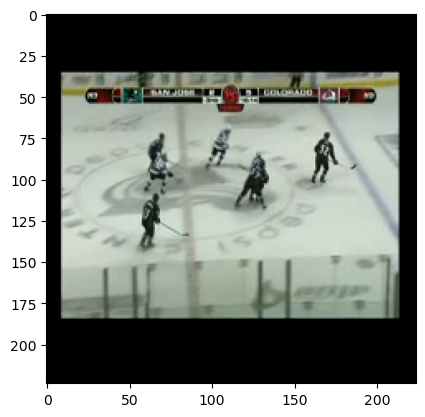

In [20]:
plt.imshow(visible_frame[1])

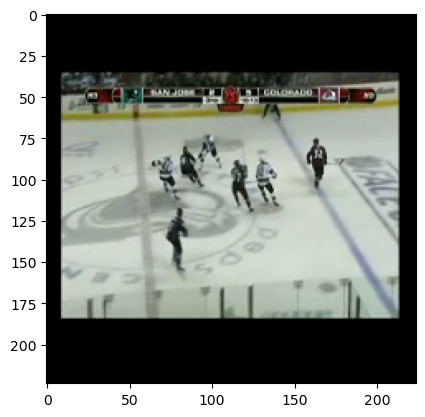

In [21]:
plt.imshow(visible_frame[16])

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.svm import SVC
import numpy as np

# generacion de la data
num_videos = 100
images_per_video = 20
img_size = 224
num_channels = 3

# generamos los frames (100 videos, 20 frames por video, 224x224x3)
data = np.random.rand(num_videos * images_per_video, img_size, img_size, num_channels)

# flatten data para SVM input (num_videos * images_per_video, img_size * img_size * num_channels)
data_flat = data.reshape((num_videos * images_per_video, img_size * img_size * num_channels))

# generar etiquetas (mitad violento, mitad no-violento)
labels = np.array([[1, 0]] * (num_videos // 2 * images_per_video) + [[0, 1]] * (num_videos // 2 * images_per_video))
labels = np.argmax(labels, axis=1)  # convertir a una etiqueta

# dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(data_flat, labels, test_size=0.2, random_state=42)

# construyendo el modelo SVM
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)

# predecir en el conjunto de prueba
y_pred = svm_model.predict(X_test)

# evaluacion
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

accuracy, conf_matrix, f1

(0.4875,
 array([[ 97, 102],
        [103,  98]], dtype=int64),
 0.4874967968549803)

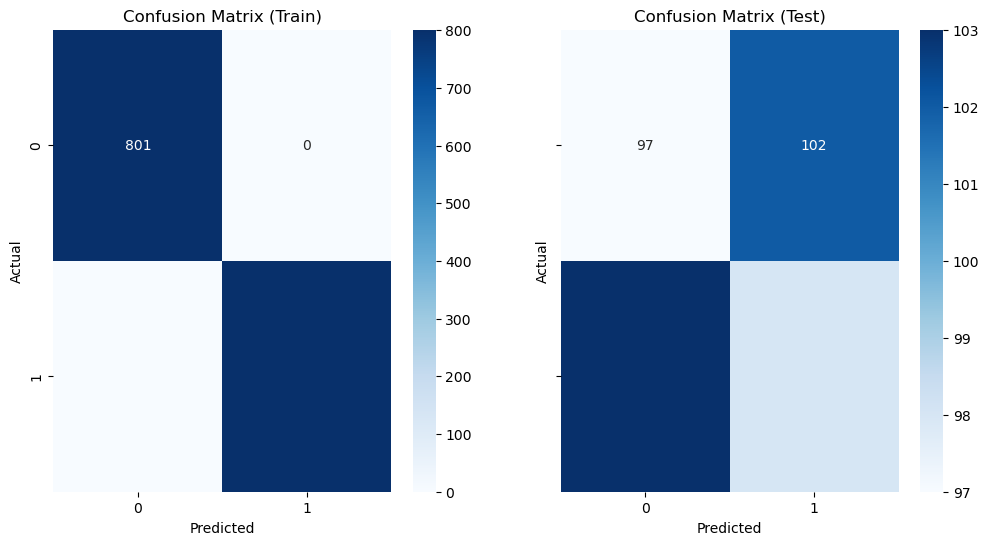

F1-score (Train): 1.0
F1-score (Test): 0.4875032031450196


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

# predecir en el conjunto de entrenamiento para ver como se desempeña el modelo con datos conocidos
y_train_pred = svm_model.predict(X_train)

# matriz de confusion para el conjunto de entrenamiento.
conf_mat_train = confusion_matrix(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred, average='weighted')

# matriz de confusion para el conjunto de pruebas
conf_mat_test = confusion_matrix(y_test, y_pred)
f1_test = f1_score(y_test, y_pred, average='weighted')

# visualizacion de la matriz de confusion.
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
sns.heatmap(conf_mat_train, annot=True, fmt="d", cmap="Blues", ax=ax[0])
ax[0].set_title('Confusion Matrix (Train)')
ax[0].set_ylabel('Actual')
ax[0].set_xlabel('Predicted')
sns.heatmap(conf_mat_test, annot=True, fmt="d", cmap="Blues", ax=ax[1])
ax[1].set_title('Confusion Matrix (Test)')
ax[1].set_ylabel('Actual')
ax[1].set_xlabel('Predicted')

plt.show()

# imprimimos la puntuacion F1 para ambos conjuntos.
print("F1-score (Train):", f1_train)
print("F1-score (Test):", f1_test)

In [24]:
image_model = VGG16(include_top=True, weights='imagenet')

In [26]:
image_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# usaremos el output de la layer prior para el final
# classification-layer es llamada fc2. esto es un fully-connected  layer.
transfer_layer = image_model.get_layer('fc2')

image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

transfer_values_size = K.int_shape(transfer_layer.output)[1]


print("The input of the VGG16 net have dimensions:",K.int_shape(image_model.input)[1:3])

print("The output of the selecter layer of VGG16 net have dimensions: ", transfer_values_size)

The input of the VGG16 net have dimensions: (224, 224)
The output of the selecter layer of VGG16 net have dimensions:  4096


In [38]:
def get_transfer_values(current_dir, file_name):

    # asignamos previamente input-batch-array para imagenes.
    shape = (_images_per_file,) + img_size_touple + (3,)

    image_batch = np.zeros(shape=shape, dtype=np.float16)

    image_batch = get_frames(current_dir, file_name)

    # asignamos output-array para los valores de transferencia.
    # utilizamos puntos flotantes de 16 bits para ahorrar memoria.
    shape = (_images_per_file, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    transfer_values = \
            image_model_transfer.predict(image_batch)

    return transfer_values

In [39]:
def proces_transfer(vid_names, in_dir, labels):

    count = 0

    tam = len(vid_names)

    shape = (_images_per_file,) + img_size_touple + (3,)

    while count<tam:

        video_name = vid_names[count]

        image_batch = np.zeros(shape=shape, dtype=np.float16)

        image_batch = get_frames(in_dir, video_name)

        shape = (_images_per_file, transfer_values_size)
        transfer_values = np.zeros(shape=shape, dtype=np.float16)

        transfer_values = \
              image_model_transfer.predict(image_batch)

        labels1 = labels[count]

        aux = np.ones([20,2])

        labelss = labels1*aux

        yield transfer_values, labelss

        count+=1

In [40]:
def make_files(n_files):

    gen = proces_transfer(names_training, in_dir, labels_training)

    numer = 1

    # lea el primer fragmento para obtener la columna. dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]

    with h5py.File('prueba.h5', 'w') as f:

        # inicializar un conjunto de datos de tamaño variable para contener la salida
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]


        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)

        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)

                # escribe el primer trozo de filas.
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:

            if numer == n_files:

                break

            # cambiamos el tamaño del conjunto de datos para acomodar el siguiente fragmento de filas
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # escribe el siguiente fragmento
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # incrementamos la columna count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]

            print_progress(numer, n_files)

            numer += 1

In [43]:
def make_files_test(n_files):

    gen = proces_transfer(names_test, in_dir, labels_test)

    numer = 1

    #leemos el primer fragmento para obtener los tipos de columna.
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]

    with h5py.File('pruebavalidation.h5', 'w') as f:

        # inicializamos un conjunto de datos de tamaño variable para contener la salida
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]

        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)

        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)

         # Escribe el primer trozo de filas.
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:

            if numer == n_files:
                              break

            # Cambiar el tamaño del conjunto de datos para acomodar el siguiente fragmento de filas
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # escribimos el siguiente trozo
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # incrementamos la columna count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]

            print_progress(numer, n_files)

            numer += 1


In [44]:
training_set = int(len(names)*0.8)
test_set = int(len(names)*0.2)

names_training = names[0:training_set]
names_test = names[training_set:]

labels_training = labels[0:training_set]
labels_test = labels[training_set:]

In [45]:
make_files(training_set)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [46]:
make_files_test(test_set)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [47]:
def process_alldata_training():

    joint_transfer=[]
    frames_num=20
    count = 0

    with h5py.File('prueba.h5', 'r') as f:

        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc

    data =[]
    target=[]

    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))

    return data, target

In [48]:
def process_alldata_test():

    joint_transfer=[]
    frames_num=20
    count = 0

    with h5py.File('pruebavalidation.h5', 'r') as f:

        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc

    data =[]
    target=[]

    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))

    return data, target

In [49]:
data, target = process_alldata_training()

In [50]:
data_test, target_test = process_alldata_test()

In [51]:
chunk_size = 4096
n_chunks = 20
rnn_size = 512

model = Sequential()
model.add(LSTM(rnn_size, input_shape=(n_chunks, chunk_size)))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

D:\conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [52]:
epoch = 200
batchS = 500

history = model.fit(np.array(data[0:720]), np.array(target[0:720]), epochs=epoch,
                    validation_data=(np.array(data[720:]), np.array(target[720:])),
                    batch_size=batchS, verbose=2)

Epoch 1/200
2/2 - 6s - 3s/step - accuracy: 0.6944 - loss: 0.3500 - val_accuracy: 0.0000e+00 - val_loss: 0.4165
Epoch 2/200
2/2 - 3s - 2s/step - accuracy: 0.0000e+00 - loss: 0.3785 - val_accuracy: 1.0000 - val_loss: 0.2809
Epoch 3/200
2/2 - 3s - 2s/step - accuracy: 1.0000 - loss: 0.2847 - val_accuracy: 1.0000 - val_loss: 0.2647
Epoch 4/200
2/2 - 3s - 2s/step - accuracy: 0.6944 - loss: 0.2603 - val_accuracy: 0.0000e+00 - val_loss: 0.2617
Epoch 5/200
2/2 - 3s - 2s/step - accuracy: 0.0000e+00 - loss: 0.2631 - val_accuracy: 0.0000e+00 - val_loss: 0.2590
Epoch 6/200
2/2 - 3s - 2s/step - accuracy: 0.0000e+00 - loss: 0.2566 - val_accuracy: 1.0000 - val_loss: 0.2511
Epoch 7/200
2/2 - 3s - 2s/step - accuracy: 1.0000 - loss: 0.2525 - val_accuracy: 1.0000 - val_loss: 0.2577
Epoch 8/200
2/2 - 3s - 2s/step - accuracy: 1.0000 - loss: 0.2569 - val_accuracy: 1.0000 - val_loss: 0.2513
Epoch 9/200
2/2 - 3s - 2s/step - accuracy: 0.6944 - loss: 0.2509 - val_accuracy: 0.0000e+00 - val_loss: 0.2515
Epoch 10/

In [53]:
result = model.evaluate(np.array(data_test), np.array(target_test))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.5199 - loss: 0.2500


In [54]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.25
compile_metrics 0.5350000262260437


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


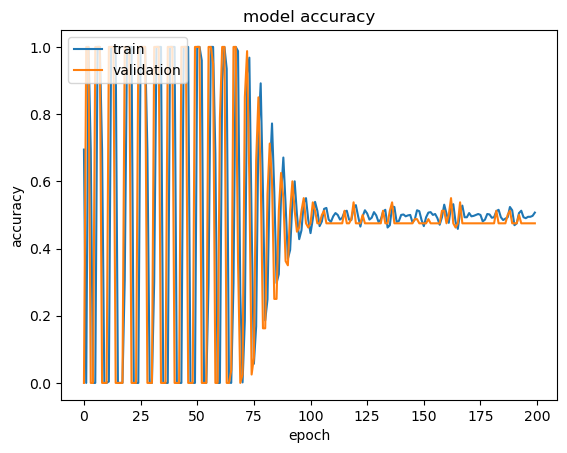

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


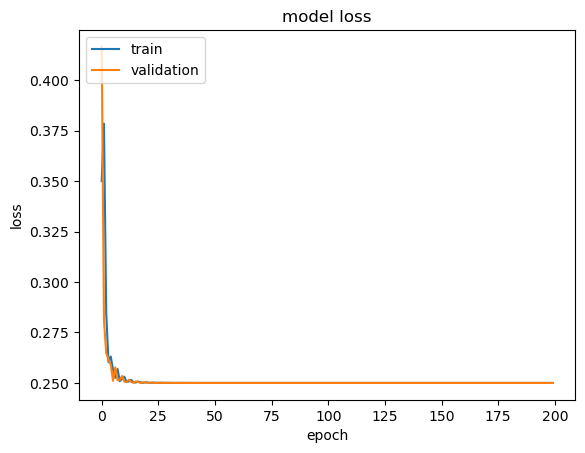

In [55]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path.eps', format='eps', dpi=1000)
plt.show()
# resumir la historia de loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


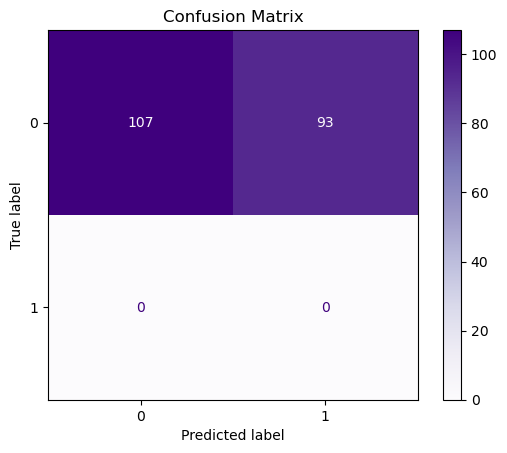

Weighted F1 Score: 0.6970684039087948


In [56]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

# Aquí va la configuración del modelo y la preparación de datos

# Matriz de predicciones y confusión.
predictions = model.predict(np.array(data_test))
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(np.array(target_test), axis=1)

# Evaluamos con matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(include_values=True, cmap='Purples')
plt.title('Confusion Matrix')
plt.show()

# Calcular F1 Score
f1 = f1_score(true_classes, predicted_classes, average='weighted')  # 'weighted' can be
print(f"Weighted F1 Score: {f1}")


In [502]:
# directorio del video a evaluar
in_dir1 = "C:/Users/ASUS/DeepTective/pruebas/"

# primero, obtenemos el nombre y la etiqueta de todo el video.
names1, labels1 = label_video_names(in_dir1)

In [504]:
for i in range(10):
    print(names1[i])

no5.avi
fi3.avi
no3.avi
fi1.avi
fi5.avi
no2.avi
no1.avi
fi2.avi
fi4.avi
no4.avi


In [505]:
for i in range(10):
    # obtener valores de transferencia
    transfer_values1 = get_transfer_values(in_dir1,names1[i])

    # hacer predicciones
    predictions1 = model.predict(np.array([transfer_values1]))

    # obtener la prediccion
    predicted_class1 = np.argmax(predictions1)

    # imprimir resultado
    if predicted_class1 == 0:
        print("El video fue clasificado como 'violento'.")
    else:
        print("El video fue clasificado como 'no violento'.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
El video fue clasificado como 'no violento'.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
El video fue clasificado como 'violento'.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
El video fue clasificado como 'no violento'.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
El video fue clasificado como 'violento'.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
El video fue clasificado como 'violento'.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
El video fue clasificado como 'no violento'.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
El video fue clasificado como 'no violento'.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
El video fue clasificado como 'violento'.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━

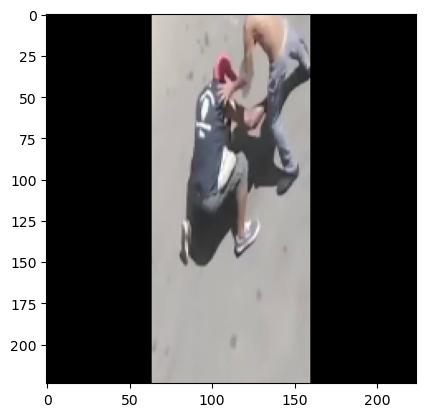

In [493]:
plt.imshow(visible_frame1[1])

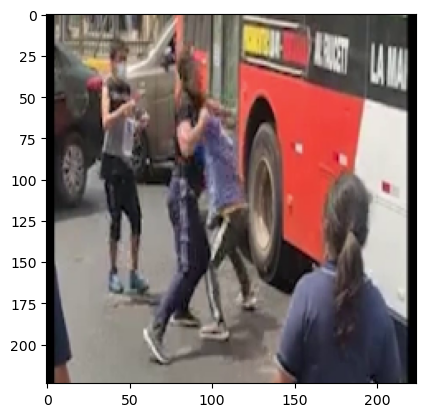

In [508]:
    #visualizacion
    frames1 = get_frames(in_dir1, names1[1])
    visible_frame1 = (frames1*255).astype('uint8')
    plt.imshow(visible_frame1[1])

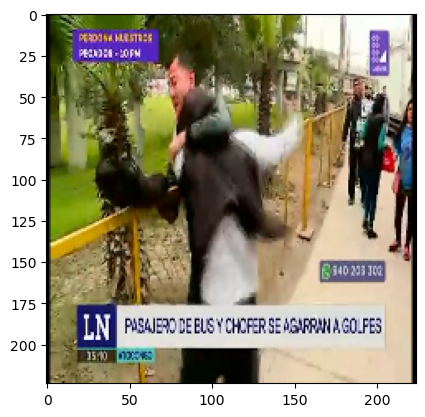

In [510]:
    #visualizacion
    frames2 = get_frames(in_dir1, names1[3])
    visible_frame2 = (frames2*255).astype('uint8')
    plt.imshow(visible_frame2[1])

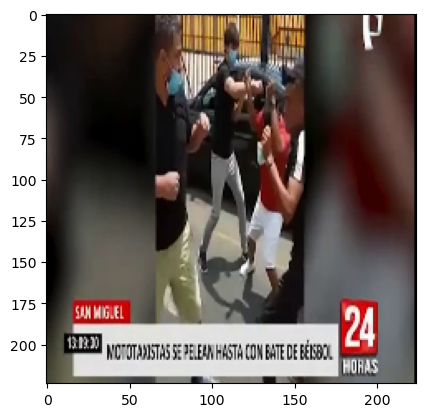

In [512]:
    #visualizacion
    frames3 = get_frames(in_dir1, names1[4])
    visible_frame3 = (frames3*255).astype('uint8')
    plt.imshow(visible_frame3[1])

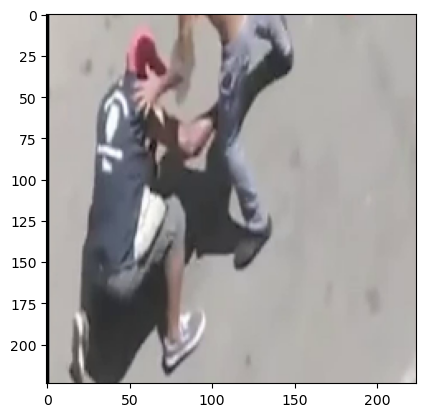

In [514]:
    #visualizacion
    frames4 = get_frames(in_dir1, names1[7])
    visible_frame4 = (frames4*255).astype('uint8')
    plt.imshow(visible_frame4[1])

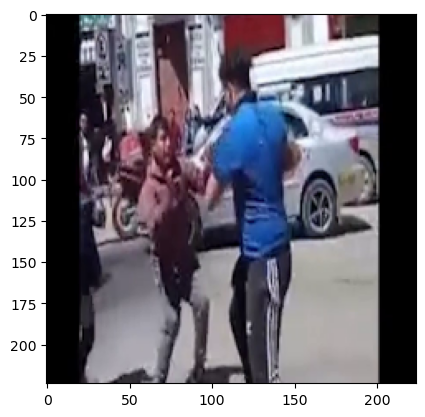

In [518]:
    #visualizacion
    frames5 = get_frames(in_dir1, names1[8])
    visible_frame5 = (frames5*255).astype('uint8')
    plt.imshow(visible_frame5[1])